In [1]:
import numpy as np
import cv2
from vidstab import VidStab
from os import listdir
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
tf.compat.v1.disable_eager_execution()
import skimage 
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from progressbar import ProgressBar
import seaborn as sns
sns.set_style("whitegrid")
from classifypixelsunet import *

Using TensorFlow backend.


#### Run segmentation and plot the different classifications for each pixel

In [2]:
### Helper Methods 
def clean_str(name):
    return name.split("/ima")[0]

def get_crop_idx(img):
    m,n = img.shape
    new_size = 130
    x_coord, y_coord, radius = get_best_circle(img)
    idx_x_l = x_coord - new_size
    idx_x_r = x_coord + new_size
    idx_y_l = y_coord - new_size
    idx_y_r = y_coord + new_size
    if(idx_y_l< 0):
        diff = 0 - idx_y_l
        idx_y_l = 0
        idx_y_r = idx_y_r+ diff
    if(idx_y_r>m):
        diff = idx_y_r - m
        idx_y_r = m
        idx_y_l = idx_y_l - diff
    if(idx_x_l < 0):
        diff = 0 - idx_x_l
        idx_x_l = 0
        idx_x_r = idx_x_r+ diff
    if(idx_x_r > n):
        diff = idx_x_r - n
        idx_x_r = n
        idx_x_l = idx_x_l - diff
    return (idx_x_l,idx_x_r,idx_y_l, idx_y_r,new_size*2)
        
        


def last_4chars(x):
    suf = x.split("_")[1]
    inte = int(suf.split(".")[0])
    return inte

def getFrame(sec,path,stable_vid_name,count):
    vidcap = cv2.VideoCapture(stable_vid_name)
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite(path+"/image_"+str(count)+".jpg", image)     # save frame as JPG file
    return hasFrames

    
def list_files1(directory, extension):
    """
    list_files1: Find files with a certain extension in the directory and return the names in a list
            Args:
                directory: Directory to be searched
                extension: the extension of the files
            Returns:
                List of files with the extension within the directory
    """
    return list(( (directory + f) for f in listdir(directory) if f.endswith('.' + extension)))

def generate_frames_vid():
    """
    generate_frames_vid: Generates frames for every video in listvideos, and save them in folder with
                         name vidName/
                    Args:
                        listvideos: List containing the path to the video files
                    Returns:
                        None
    """
    try:
        os.mkdir("StableFrames", 755)
    except OSError:
        pass
    try:
        os.mkdir("StableFrames/videos", 755)
    except OSError:
        pass
    listvideos = list_files1('videos/','avi')
    for video in listvideos:
        path = "StableFrames/" + video.split('.avi')[0]
        try:
            os.mkdir(path, 755)
        except OSError:
            pass
        stable_vid_name = 'stable_video.avi'
        stabilizer = VidStab(kp_method='DENSE')
        stabilizer.stabilize(input_path=video, output_path=stable_vid_name)
        sec = 0
        frameRate = 0.5 #//it will capture image in each 0.5 second
        count=1
        success = getFrame(sec,path,stable_vid_name,count)
        while success:
            count = count + 1
            sec = sec + frameRate
            sec = round(sec, 2)
            success = getFrame(sec,path,stable_vid_name,count)
 
### Generate train_test data
def generate_train_testdata(k):
    """
    generate_train_testdata: Generate table for path to input and output data
                        Args:
                            k: Distance for the next frame
                        Returns:
                             df containg the input path and the corresponding output predicted
    """
    data = pd.DataFrame(columns=["input", "output"])
    directory = "StableFrames/videos"
    subdir = listdir(directory)
    for subd in subdir:
        images = sorted(listdir(directory + "/" + subdir[0]), key=last_4chars)
        for idx, img in enumerate(images):
            base_path = directory + "/" + subd + "/"
            input_img = base_path + img
            output_img = base_path + "image_" + str(idx+k+1) + ".jpg"
            if os.path.isfile(output_img):
                temp_df = pd.DataFrame([[input_img,output_img]], columns=["input", "output"])
                data =  pd.concat((data,temp_df))
    return data     



def get_best_circle(img1):
    """
    get_best_circle: Use hough transform to find the best circle
                Args: 
                     img1: Grayscale image on which to find the circle
                Returns:
                    circle: list containing the x-coords, y-coords of the center
                            and radius for the circle. 
    """
    edges = canny(img1, sigma=2, low_threshold=10, high_threshold=50)
    hough_radii = np.arange(50, 150, 2)
    hough_res = hough_circle(edges, hough_radii)
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               total_num_peaks=3)
    max_idx = np.argmax(radii)
    max_x = cx[max_idx]
    max_y = cy[max_idx]
    max_radii = radii[max_idx]
    return ([max_x, max_y, max_radii])

def preprocess_image_seg(img1):
    """
    preprocess_image: Find the relevant information, and shift to the center
    
                Args:
                    img1: Image on which to perform the preprocessing
                Returns:
                    masked_img: Image with preprocessing done
    
    """
    idx_x_l,idx_x_r,idx_y_l, idx_y_r,new_size = get_crop_idx(img1)
    new_img = img1[idx_y_l:idx_y_r,idx_x_l:idx_x_r]
    return (new_img,new_size)
    

def get_layers(mainModel, start_idx, end_idx, need_summary= False):
    """
    get_layers: get Layers from start_idx to end_idx, and return a new model extracts layers
                from start_idx to end_idx
            Args:
                mainModel: The model from which to extract layers
                start_idx: start_idx to extract
                end_idx  : end_idx to extract
            need_summary : If we need the summary
            Returns:
                model: New Model with extracted layers
    
    """
    model = tf.keras.Sequential()
    for i in range(start_idx, end_idx+1):
        model.add(mainModel.get_layer(index = i))
    if(need_summary):
        model.summary()
    return model
    
def get_embeddings(train_imgs, mainModel, start_idx, end_idx):
    """
    get_embeddings: Get embeddings for train_imgs after extracting layers from mainModel
                    from start_idx to end_idx
                Args:
                    train_imgs: Images to get embeddings from
                    mainModel: The model from which to extract layers
                    start_idx: start_idx to extract
                    end_idx  : end_idx to extract
                Returns:
                    nothing
    """
    m = train_imgs.shape[0]
    embedding_model = get_layers(mainModel, 0,5)
    embeddings = embedding_model.predict(train_imgs)
    embeddings = embeddings.reshape(m,2)
    return embeddings


        
def only_read(X):
    """
    read_from_path: Read images from path, preprocess, and append to numpy data frame.
                Args:
                    X: List containing all the paths
                Returns:
                    data: numpy array containing all of the data
    """
    img_size = 500
    new_img_size = 260
    data = np.empty(shape = [1,new_img_size,new_img_size])
    pbar = ProgressBar()
    print("Starting Reading and Preprocessing.\n")
    
    for i in pbar(X):
        img = cv2.imread(i, 0)
        img,new_size = preprocess_image_seg(img)
        img = img.reshape(1,new_size,new_size)
        data = np.append(data,img, axis = 0)
    print("Done Reading and Preprocessing.\n")
    data = data.reshape(len(X)+1,new_size,new_size,1)
    return data


#### Generate the train and test data frame video
##### Procedure is as follows
- generate_frame_vid generates the image to be use for training from the video files, after stabalizing the video using "DENSE" method
- we use generate_train_testdata to contain the path of the image as input, and the output as the frame frame_dist frame in the future
- We then preprocess the image. First we use hough transform to find circles within a radius from 50 to 150. We use the maximum of these circles as after trial and error we foudn this to be a good method to extract the frame we are interested in 
- Next we crop this image to get only the circle of interest and a few pixels around it using the center location of the circle

In [3]:
#generate_frames_vid()
train_test_data = generate_train_testdata(1)  

In [4]:
inp = train_test_data.iloc[:,0].values.tolist()
inp_d = only_read(inp)
out = train_test_data.iloc[:,1].values.tolist()
out_d = only_read(out)



Starting Reading and Preprocessing.



100% |########################################################################|


Done Reading and Preprocessing.

Starting Reading and Preprocessing.



Done Reading and Preprocessing.



In [5]:
m = inp_d.shape[0]
new_img_size = 260

inp_d = inp_d[1:m,:,:,0].reshape(m-1,new_img_size,new_img_size,1)
out_d = out_d[1:m,:,:,0].reshape(m-1,new_img_size,new_img_size,1)

#### Use Pretrained U-net for image segmentation

In [6]:

model = unet_initialize((new_img_size,new_img_size))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [11]:
def plot_unet(img, out):
    plt.figure(figsize=(15,15))
    plt.subplot(1,4,1)
    plt.title("Original Image")
    plt.imshow(img, cmap = "gray")
    plt.subplot(1,4,2)
    plt.title("Background classification")
    plt.imshow(out[:,:,0], cmap = "gray")
    plt.subplot(1,4,3)
    plt.title("nuclei classification")
    plt.imshow(out[:,:,1], cmap = "gray")
    plt.subplot(1,4,4)
    plt.title("boundary classification")
    plt.imshow(out[:,:,2], cmap = "gray")


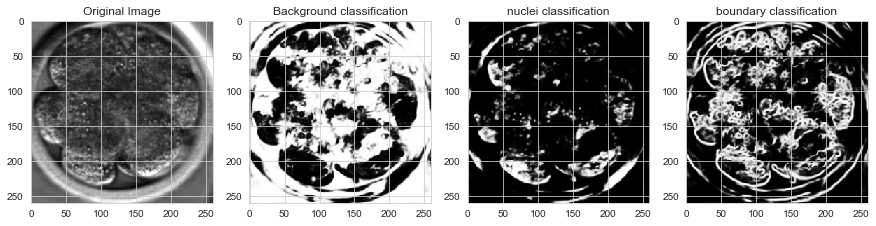

In [12]:
idx = 11
img = inp_d[idx,:,:]
n = img.shape[0]
img = img.reshape(n,n)
out = unet_classify(model, img)
plot_unet(img,out)

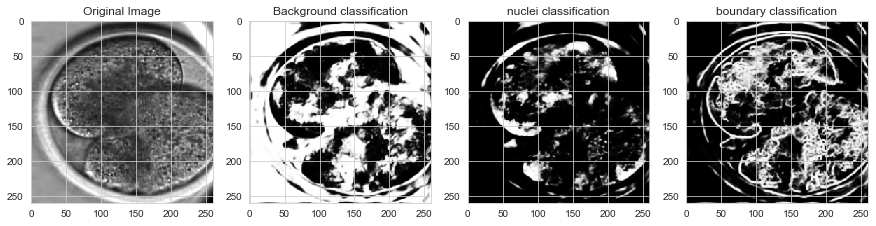

In [14]:
idx = 15
img = inp_d[idx,:,:]
n = img.shape[0]
img = img.reshape(n,n)
out = unet_classify(model, img)
plot_unet(img,out)